In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [25]:
# Загрузка данных
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/moves.csv')

# Предварительный анализ данных
print(data.head())
print(data.describe())

  Best Move  Best Move Eval Real Move  Ranking Real Move  Real Move Eval  \
0      e2e4            0.38      e2e4                  1            0.38   
1      e7e5            0.23      e7e5                  1            0.23   
2      g1f3            0.23      g1f3                  1            0.23   
3      b8c6            0.28      b8c6                  1            0.28   
4      f1b5            0.28      f1c4                  3            0.17   

   plycount player  difference  move_timestamp  move_time  ...    use  \
0         1  white       -0.00           177.3        3.7  ...  False   
1         2  black        0.00           176.7        4.3  ...   True   
2         3  white       -0.00           177.3        1.0  ...  False   
3         4  black        0.00           176.7        1.0  ...   True   
4         5  white        0.11           172.7        5.6  ...  False   

   is_top1  is_top3  is_top5 move_timestamp_bin  is_endgame game_length  \
0     True     True     True 

In [26]:
# Проверка наличия необходимых столбцов
required_columns = ['Real Move Eval', 'plycount']
for col in required_columns:
    if col not in data.columns:
        raise KeyError(f"Столбец '{col}' отсутствует в данных.")

# Удаление строк с нулевыми значениями в необходимых столбцах
data = data.dropna(subset=required_columns)

# Просмотр первых строк данных
print(data.head())

  Best Move  Best Move Eval Real Move  Ranking Real Move  Real Move Eval  \
0      e2e4            0.38      e2e4                  1            0.38   
1      e7e5            0.23      e7e5                  1            0.23   
2      g1f3            0.23      g1f3                  1            0.23   
3      b8c6            0.28      b8c6                  1            0.28   
4      f1b5            0.28      f1c4                  3            0.17   

   plycount player  difference  move_timestamp  move_time  ...    use  \
0         1  white       -0.00           177.3        3.7  ...  False   
1         2  black        0.00           176.7        4.3  ...   True   
2         3  white       -0.00           177.3        1.0  ...  False   
3         4  black        0.00           176.7        1.0  ...   True   
4         5  white        0.11           172.7        5.6  ...  False   

   is_top1  is_top3  is_top5 move_timestamp_bin  is_endgame game_length  \
0     True     True     True 

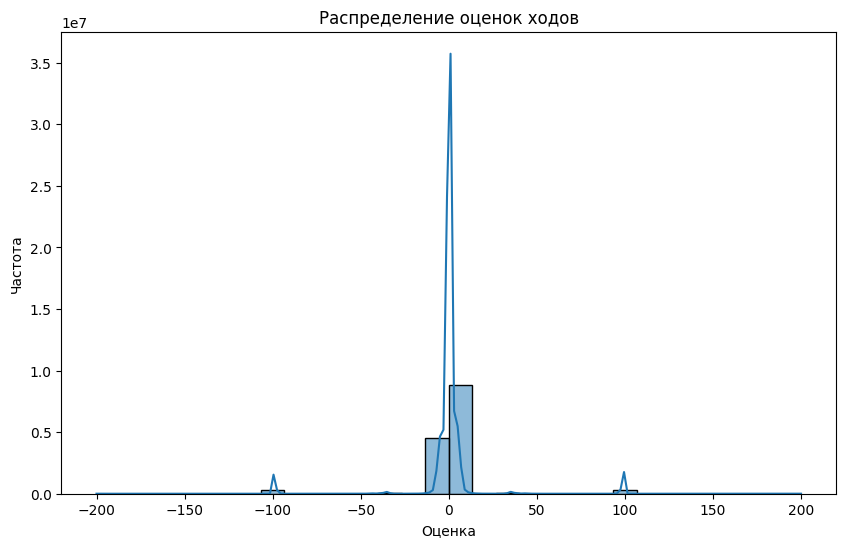

In [27]:
# Шаг 2: Анализ распределения оценок ходов
plt.figure(figsize=(10, 6))
sns.histplot(data['Real Move Eval'], bins=30, kde=True)
plt.title('Распределение оценок ходов')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()


In [28]:
# Шаг 3: Выявление партий с аномальными изменениями
data['evaluation_diff'] = data['Real Move Eval'].diff()

# Вычисление Z-оценки для выявления аномалий
mean_diff = data['evaluation_diff'].mean()
std_diff = data['evaluation_diff'].std()
data['z_score'] = (data['evaluation_diff'] - mean_diff) / std_diff

In [29]:
# Определяем порог для аномалий (например, Z-оценка > 2)
anomalies = data[data['z_score'].abs() > 3]

# Выводим партии с аномальными изменениями
print(anomalies)

         Best Move  Best Move Eval Real Move  Ranking Real Move  \
205           c1d2           -7.92      c2c3                 -1   
206           f8c8          -99.00      b3b6                  3   
207           f1e2           -8.93      d3d4                 -1   
209           e2e4            0.34      e2e4                  1   
701           g3f2           -3.64      g3h4                  4   
...            ...             ...       ...                ...   
14114887      f8e8           34.17      c6c5                  2   
14114888      g5c5           99.00      b4c5                  3   
14114889      f8e8           99.00      f8e8                  1   
14114890      c5b4           99.00      b1c1                  2   
14114891      e8d7           41.19      e2h2                 -1   

          Real Move Eval  plycount player  difference  move_timestamp  \
205               -99.00        55  white       91.08            25.0   
206                -8.71        56  black       9

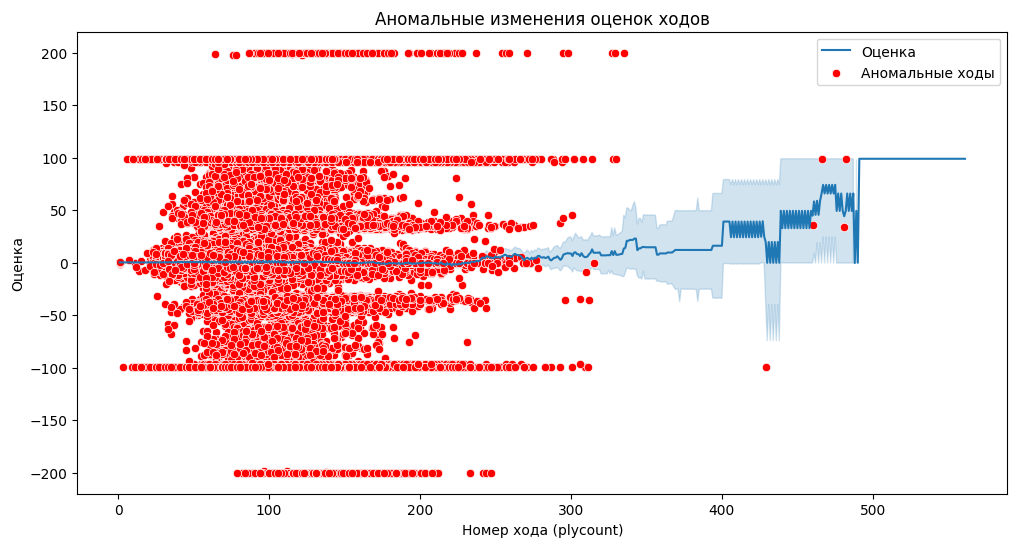

In [30]:
# Шаг 4: Визуализация аномалий
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='plycount', y='Real Move Eval', label='Оценка')
sns.scatterplot(data=anomalies, x='plycount', y='Real Move Eval', color='red', label='Аномальные ходы')
plt.title('Аномальные изменения оценок ходов')
plt.xlabel('Номер хода (plycount)')
plt.ylabel('Оценка')
plt.legend()
plt.show()


In [31]:
# Шаг 5: Классификация подозрительных ходов
data['label'] = np.where(data['z_score'].abs() > 2, 1, 0)

# Определяем признаки и целевую переменную
X = data[['Real Move Eval', 'plycount', 'evaluation_diff']]
y = data['label']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Обучаем модель
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [33]:
# Предсказания на тестовой выборке
y_pred = model.predict(X_test)

In [34]:
# Оценка качества модели
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2769982       1]
 [      0   52998]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2769983
           1       1.00      1.00      1.00     52998

    accuracy                           1.00   2822981
   macro avg       1.00      1.00      1.00   2822981
weighted avg       1.00      1.00      1.00   2822981



In [35]:
# Шаг 6: Визуализация результатов классификации
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)


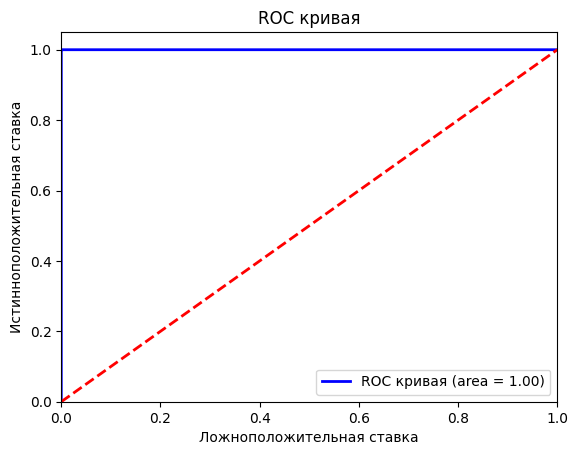

In [36]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная ставка')
plt.ylabel('Истинноположительная ставка')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()

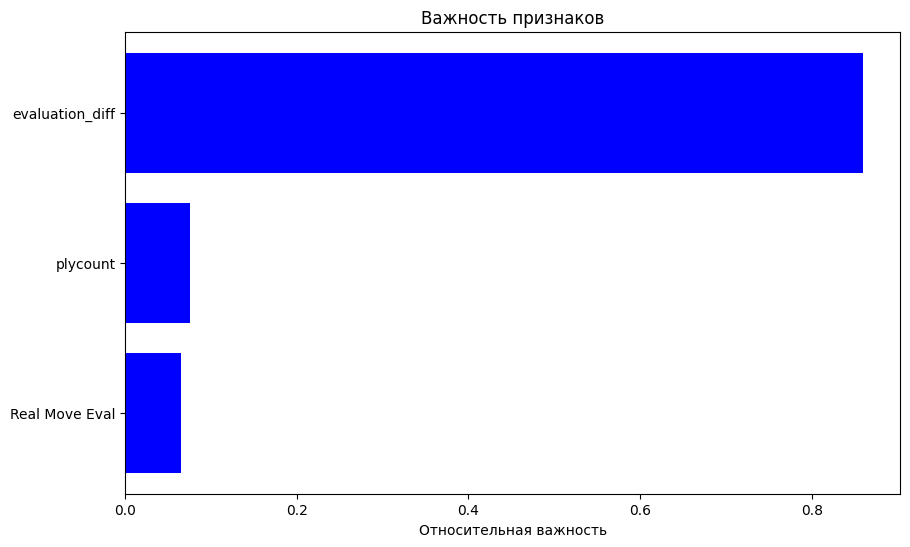

In [37]:
# Визуализация важности признаков
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Относительная важность')
plt.show()

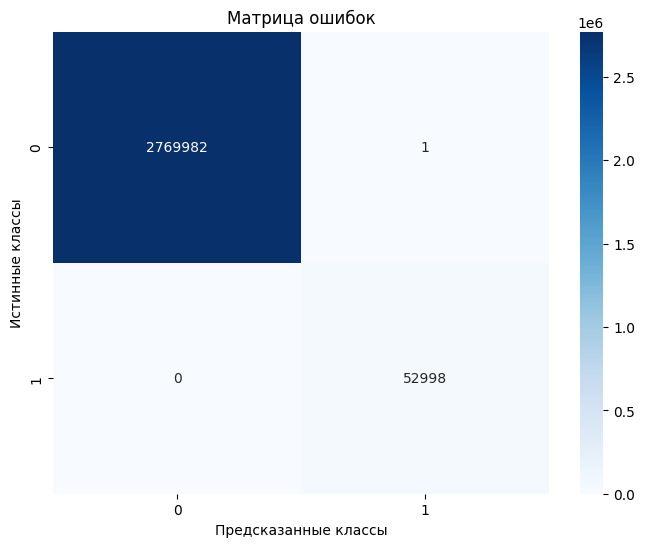

In [38]:
# Визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()



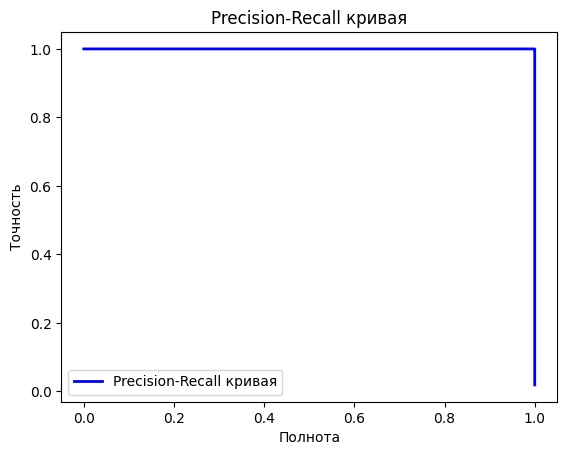

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Визуализация Precision-Recall кривой
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall кривая')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Precision-Recall кривая')
plt.legend(loc="lower left")
plt.show()




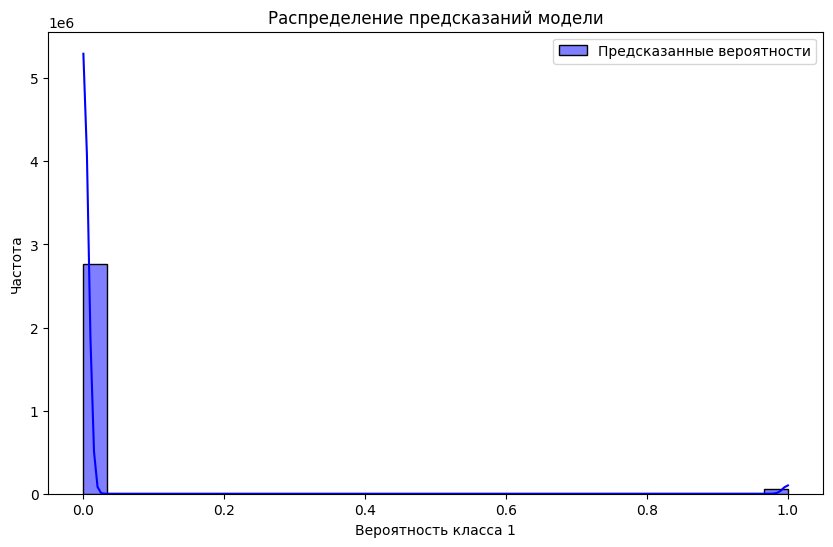

In [41]:
# Визуализация распределения предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(model.predict_proba(X_test)[:, 1], bins=30, kde=True, color='blue', label='Предсказанные вероятности')
plt.title('Распределение предсказаний модели')
plt.xlabel('Вероятность класса 1')
plt.ylabel('Частота')
plt.legend()
plt.show()

Вуу
вариант1

Вариант 2